In [1]:
import json
from influxdb import InfluxDBClient
import pandas as pd
from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(50)

In [2]:
with open("../../../../secrets/homevision.json") as handler:
    creds = json.load(handler)

In [3]:
idb = InfluxDBClient(**creds)
idb.ping()

'1.8.1'

In [4]:
def get_points(connection, query, database):
    result = connection.query(query, database=database)
    frame = pd.DataFrame(result.get_points())
    frame["time"] = pd.to_datetime(frame["time"])
    return frame

### SDC30

In [5]:
co2 = get_points(idb, "SELECT * FROM scd30 WHERE time >= '2021-08-01';", "homevision")
co2

,time,CO2,RH,T,device,location,owner
0,2021-08-01 00:00:14.665830+00:00,567.090759,50.433613,24.942894,bluebox-01,home-lab,jlandercy
1,2021-08-01 00:00:31.686256+00:00,567.109070,50.410419,24.929543,bluebox-01,home-lab,jlandercy
2,2021-08-01 00:00:47.250102+00:00,567.323364,50.538620,24.900169,bluebox-01,home-lab,jlandercy
3,2021-08-01 00:01:04.248512+00:00,568.063171,50.538757,24.929543,bluebox-01,home-lab,jlandercy
4,2021-08-01 00:01:20.346114+00:00,568.112244,50.472427,24.913521,bluebox-01,home-lab,jlandercy
...,...,...,...,...,...,...,...
286130,2021-09-24 07:56:46.740637+00:00,423.121521,55.531658,23.618408,bluebox-01,home-lab,jlandercy
286131,2021-09-24 07:57:02.893482+00:00,422.458954,55.296696,23.661133,bluebox-01,home-lab,jlandercy
286132,2021-09-24 07:57:18.828718+00:00,423.857361,55.453129,23.661133,bluebox-01,home-lab,jlandercy
286133,2021-09-24 07:57:35.407590+00:00,423.537872,55.489937,23.661133,bluebox-01,home-lab,jlandercy


In [6]:
co2 = co2.set_index("time").resample("1H").mean()

In [7]:
co2.columns = ["CO2/indoor/scd30 (ppm)", "RH/indoor/scd30 (%)", "T/indoor/scd30 (°C)"]

In [8]:
co2.columns.name = "seriekey"

<AxesSubplot:xlabel='time'>

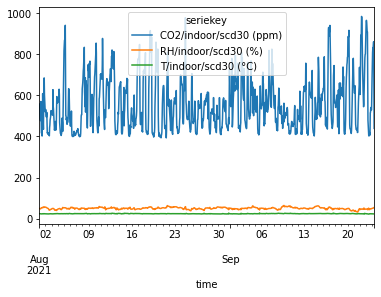

In [9]:
co2.plot()

### LTH65

In [10]:
Tnode = get_points(idb, 
      "SELECT * FROM device_frmpayload_data_node_temperature WHERE time >= '2021-08-01';", "chirpstack_lht65")
Tnode

,time,application_name,dev_eui,device_name,f_port,location,value
0,2021-08-01 00:05:37.909000+00:00,home-comfort,a84041000181bd79,node-T041,2,living-room,23.71
1,2021-08-01 00:06:05.716000+00:00,home-comfort,a84041000181bb73,node-T012,2,kitchen,23.81
2,2021-08-01 00:07:34.793000+00:00,home-comfort,a84041000181bd52,node-T040,2,bathroom-parent,23.32
3,2021-08-01 00:11:05.908000+00:00,home-comfort,a84041000181bd7d,node-T046,2,bedroom-child-right,23.67
4,2021-08-01 00:13:47.422000+00:00,home-comfort,a84041000181bd48,node-T042,2,bathroom-children,23.61
...,...,...,...,...,...,...,...
31096,2021-09-24 07:50:02.950000+00:00,home-comfort,a84041000181bd7d,node-T046,2,bedroom-child-right,21.07
31097,2021-09-24 07:52:48.926000+00:00,home-comfort,a84041000181bd48,node-T042,2,bathroom-children,21.73
31098,2021-09-24 07:52:54.197000+00:00,home-comfort,a84041000181bd60,node-T043,2,bedroom-child-left,21.50
31099,2021-09-24 07:54:16.695000+00:00,home-comfort,a84041000181bd5a,node-T047,2,bedroom-parent,21.31


In [11]:
Tnode["time"] = Tnode["time"].dt.floor("1H")
Tnode = Tnode.pivot_table(index="time", columns="location", values="value")

In [12]:
Tnode = Tnode[["living-room", "outdoor"]]
Tnode[Tnode>100] = None

In [13]:
Tnode.columns.name = "seriekey"

In [14]:
Tnode.columns = ["T/indoor/lht65 (°C)", "T/outdoor/lht65 (°C)"]

<AxesSubplot:xlabel='time'>

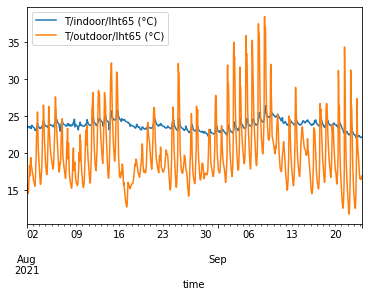

In [15]:
Tnode.plot()

In [16]:
RHnode = get_points(idb, 
      "SELECT * FROM device_frmpayload_data_node_humidity WHERE time >= '2021-08-01';", "chirpstack_lht65")
RHnode

,time,application_name,dev_eui,device_name,f_port,location,value
0,2021-08-01 00:05:37.909000+00:00,home-comfort,a84041000181bd79,node-T041,2,living-room,55.5
1,2021-08-01 00:06:05.716000+00:00,home-comfort,a84041000181bb73,node-T012,2,kitchen,55.8
2,2021-08-01 00:07:34.793000+00:00,home-comfort,a84041000181bd52,node-T040,2,bathroom-parent,58.3
3,2021-08-01 00:11:05.908000+00:00,home-comfort,a84041000181bd7d,node-T046,2,bedroom-child-right,59.9
4,2021-08-01 00:13:47.422000+00:00,home-comfort,a84041000181bd48,node-T042,2,bathroom-children,58.6
...,...,...,...,...,...,...,...
31096,2021-09-24 07:50:02.950000+00:00,home-comfort,a84041000181bd7d,node-T046,2,bedroom-child-right,65.6
31097,2021-09-24 07:52:48.926000+00:00,home-comfort,a84041000181bd48,node-T042,2,bathroom-children,64.0
31098,2021-09-24 07:52:54.197000+00:00,home-comfort,a84041000181bd60,node-T043,2,bedroom-child-left,65.6
31099,2021-09-24 07:54:16.695000+00:00,home-comfort,a84041000181bd5a,node-T047,2,bedroom-parent,64.9


In [17]:
RHnode["time"] = RHnode["time"].dt.floor("1H")
RHnode = RHnode.pivot_table(index="time", columns="location", values="value")

In [18]:
RHnode.columns.name = "seriekey"

<AxesSubplot:xlabel='time'>

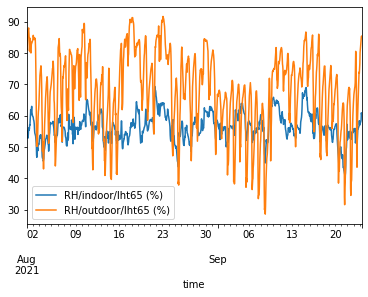

In [19]:
RHnode = RHnode[["living-room", "outdoor"]]
RHnode.columns = ["RH/indoor/lht65 (%)", "RH/outdoor/lht65 (%)"]
RHnode.plot()

### BME280

In [20]:
p = get_points(idb, 
      "SELECT * FROM bme280 WHERE time >= '2021-08-01';", "homevision")
p

,time,device,humidity,location,measuring,owner,pressure,temperature,updated
0,2021-08-01 00:00:09.776820+00:00,bluebox-01,31.827764,home-lab,0,jlandercy,1007.288902,31.679309,0
1,2021-08-01 00:00:19.776826+00:00,bluebox-01,31.857528,home-lab,0,jlandercy,1007.268425,31.664176,0
2,2021-08-01 00:00:29.796057+00:00,bluebox-01,31.869550,home-lab,0,jlandercy,1007.248678,31.652826,0
3,2021-08-01 00:00:39.796544+00:00,bluebox-01,31.887207,home-lab,0,jlandercy,1007.255702,31.652826,0
4,2021-08-01 00:00:49.798433+00:00,bluebox-01,31.899047,home-lab,0,jlandercy,1007.236657,31.649673,0
...,...,...,...,...,...,...,...,...,...
467630,2021-09-24 07:57:12.216727+00:00,bluebox-01,34.836633,home-lab,0,jlandercy,1014.415857,30.367489,0
467631,2021-09-24 07:57:22.815167+00:00,bluebox-01,34.866042,home-lab,0,jlandercy,1014.409785,30.361499,0
467632,2021-09-24 07:57:32.827689+00:00,bluebox-01,34.854234,home-lab,0,jlandercy,1014.432375,30.366858,0
467633,2021-09-24 07:57:42.827689+00:00,bluebox-01,34.842360,home-lab,0,jlandercy,1014.435732,30.376631,0


In [21]:
p = p.set_index("time").resample("1H").mean()[["humidity", "pressure", "temperature"]]

In [22]:
p.columns.name = "seriekey"

In [23]:
p.columns = ["RH/indoor/bme280 (%)", "p/indoor/bme280 (hPa)", "T/indoor/bme280 (°C)"]

<AxesSubplot:xlabel='time'>

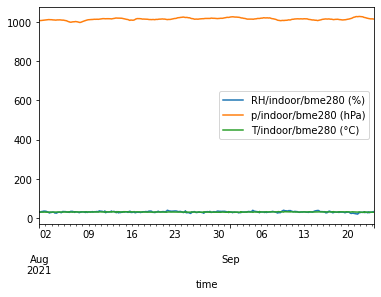

In [24]:
p.plot()

In [25]:
client = Irceline()

In [26]:
sel = client.select(measurekey=["^T$", "RH", "CO2"], sitekey="41")
sel

,serieid,siteid,measureid,serieunits,measurekey,measurename,sitekey,sitename,seriekey,molarmass,...,nuts1id,nuts2id,nuts3id,nuts1name,nuts2name,nuts3name,lauid,launame,started,stopped
42,6612,1119,71,ppm,CO2,Carbon Dioxide,41R002,Ixelles,CO2/41R002 (ppm),44.0,...,BE1,BE10,BE100,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,Brussels,de Bruxelles-Capitale/van Brussel-Hoofdstad,BE_21009,Ixelles,2012-05-29 01:00:00+00:00,2021-06-16 10:00:00+00:00
43,6619,1122,71,ppm,CO2,Carbon Dioxide,41R012,Uccle,CO2/41R012 (ppm),44.0,...,BE1,BE10,BE100,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,Brussels,de Bruxelles-Capitale/van Brussel-Hoofdstad,BE_21016,Uccle,2012-05-29 01:00:00+00:00,2021-09-24 07:00:00+00:00
462,10793,1118,62106,%,RH,relative humidity,41R001,Molenbeek-Saint-Jean,RH/41R001 (%),NaN,...,BE1,BE10,BE100,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,Brussels,de Bruxelles-Capitale/van Brussel-Hoofdstad,BE_21012,Molenbeek-Saint-Jean,2019-01-01 01:00:00+00:00,2021-09-24 07:00:00+00:00
463,10794,1122,62106,%,RH,relative humidity,41R012,Uccle,RH/41R012 (%),NaN,...,BE1,BE10,BE100,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,Brussels,de Bruxelles-Capitale/van Brussel-Hoofdstad,BE_21016,Uccle,2019-01-01 01:00:00+00:00,2021-09-24 07:00:00+00:00
574,99914,1113,62101,°C,T,temperature,41B011,Berchem-Sainte-Agathe,T/41B011 (°C),NaN,...,BE1,BE10,BE100,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,Brussels,de Bruxelles-Capitale/van Brussel-Hoofdstad,BE_21003,Berchem-Sainte-Agathe,2014-01-01 01:00:00+00:00,2015-10-23 08:00:00+00:00
575,99917,1118,62101,°C,T,temperature,41R001,Molenbeek-Saint-Jean,T/41R001 (°C),NaN,...,BE1,BE10,BE100,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,Brussels,de Bruxelles-Capitale/van Brussel-Hoofdstad,BE_21012,Molenbeek-Saint-Jean,2014-01-01 01:00:00+00:00,2021-09-25 00:00:00+00:00
583,99941,1122,62101,°C,T,temperature,41R012,Uccle,T/41R012 (°C),NaN,...,BE1,BE10,BE100,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,Brussels,de Bruxelles-Capitale/van Brussel-Hoofdstad,BE_21016,Uccle,2014-01-01 01:00:00+00:00,2018-07-24 07:00:00+00:00


In [27]:
recs = client.get_records(sel, start="2021-08-01")

In [28]:
ircel = recs.merge(sel[["serieid", "seriekey"]]).pivot_table(index="start", columns="seriekey", values="value")

In [29]:
ircel = ircel.drop(["RH/41R012 (%)"], axis=1)

In [30]:
ircel.index.name = "time"

In [31]:
ircel

seriekey,CO2/41R012 (ppm),RH/41R001 (%),T/41R001 (°C)
time,,,
2021-08-01 00:00:00+00:00,414.5,91.0,13.50
2021-08-01 01:00:00+00:00,412.5,91.5,13.20
2021-08-01 02:00:00+00:00,411.0,92.0,13.25
2021-08-01 03:00:00+00:00,413.0,92.0,13.30
2021-08-01 04:00:00+00:00,413.0,92.0,13.55
...,...,...,...
2021-09-24 02:00:00+00:00,405.5,90.0,15.45
2021-09-24 03:00:00+00:00,410.5,89.0,15.45
2021-09-24 04:00:00+00:00,411.5,89.5,15.45


<AxesSubplot:xlabel='time'>

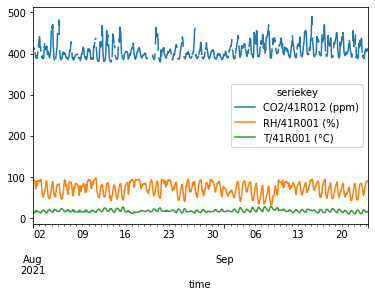

In [32]:
ircel.plot()

In [37]:
data = pd.concat([co2, Tnode, RHnode, p, ircel], axis=1)
data

,CO2/indoor/scd30 (ppm),RH/indoor/scd30 (%),T/indoor/scd30 (°C),T/indoor/lht65 (°C),T/outdoor/lht65 (°C),RH/indoor/lht65 (%),RH/outdoor/lht65 (%),RH/indoor/bme280 (%),p/indoor/bme280 (hPa),T/indoor/bme280 (°C),CO2/41R012 (ppm),RH/41R001 (%),T/41R001 (°C)
time,,,,,,,,,,,,,
2021-08-01 00:00:00+00:00,557.743626,50.055070,24.856091,23.670000,15.723333,55.233333,81.200000,31.624319,1007.077279,31.590608,414.5,91.0,13.50
2021-08-01 01:00:00+00:00,549.320450,49.286815,24.806696,23.630000,15.230000,54.533333,81.033333,31.165720,1006.853882,31.533173,412.5,91.5,13.20
2021-08-01 02:00:00+00:00,533.576876,48.229155,24.853592,23.620000,14.756667,53.866667,83.133333,30.556481,1006.770912,31.560379,411.0,92.0,13.25
2021-08-01 03:00:00+00:00,491.597841,47.941203,24.688690,23.540000,14.546667,53.033333,86.066667,30.385586,1006.771652,31.392291,413.0,92.0,13.30
2021-08-01 04:00:00+00:00,477.637309,48.232575,24.499253,23.483333,14.520000,52.800000,86.800000,30.551965,1006.740060,31.215793,413.0,92.0,13.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-24 03:00:00+00:00,828.533368,51.840831,23.845706,22.116667,16.560000,57.933333,82.100000,32.408469,1014.466316,30.629759,410.5,89.0,15.45
2021-09-24 04:00:00+00:00,838.881638,52.047797,23.797859,22.093333,16.493333,58.233333,83.300000,32.547669,1014.405154,30.581244,411.5,89.5,15.45
2021-09-24 05:00:00+00:00,860.335362,52.318859,23.811030,22.080000,16.493333,58.700000,84.066667,32.723404,1014.383543,30.590072,410.0,90.0,15.50


<AxesSubplot:xlabel='time'>

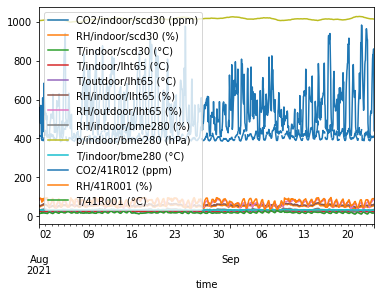

In [38]:
data.plot()

In [40]:
data.shape

(1304, 13)

In [41]:
data.to_pickle("data.pickle")